# Question 1: GPT-2 style autoregressive language model

In [1]:
import time

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext.data as data
from models.attention import MultiHeadAttention
from models.embedder import Embedder, FeedForward, Norm, PositionalEncoder, get_clones
from transformers import GPT2Tokenizer

/home/ubuntu/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


## Decoder

* the first attention mechanism in each decoder layer is self-attention
    * operates solely within the decoder
    * focuses on the target sequence
    * we're going to keep this
* the second attention mechanism is the encoder-decoder attention
    * this is "cross-attention"
    * One of the sequences serves as a query input, while the other as a key and value inputs
* in a GPT-2-style autoregressive model
    * the encoder-decoder attention is not used because there is no distinct encoder phase
    * the model is solely based on a stacked decoder-like architecture with self-attention layers
    * this only attends to previous positions in the input sequence (using a no-peak mask)

In [3]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.dropout_1 = nn.Dropout(dropout)
        self.attn_1 = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.ff = FeedForward(d_model, dropout=dropout)
        self.norm_2 = Norm(d_model)
        self.dropout_2 = nn.Dropout(dropout)

    def forward(self, x, trg_mask):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn_1(x2, x2, x2, trg_mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.ff(x2))
        return x

Since there's no longer an encoder output (`e_outputs`), we can remove it.

In [4]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads, dropout):
        super().__init__()
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model, dropout=dropout)
        self.layers = get_clones(DecoderLayer(d_model, heads, dropout), N)
        self.norm = Norm(d_model)

    def forward(self, trg, trg_mask):
        x = self.embed(trg)
        x = self.pe(x)
        for layer in self.layers:
            x = layer(x, trg_mask)
        return self.norm(x)

## Transformer

* the Transformer below essentially functions like an autoregressive language model, similar to GPT-2.
* This model doesn't have an encoder and uses only a decoder.
* we're now using a single vocab size since we don't have a source and target vocab.

```python
class Transformer(nn.Module):
    def __init__(self, src_vocab, trg_vocab, d_model, N, heads, dropout):
        super().__init__()
        self.encoder = Encoder(src_vocab, d_model, N, heads, dropout) # remove this
        self.decoder = Decoder(trg_vocab, d_model, N, heads, dropout)
        self.out = nn.Linear(d_model, trg_vocab)

    def forward(self, src, trg, src_mask, trg_mask): # now only target vocab
        e_outputs = self.encoder(src, src_mask)
        # print("DECODER")
        d_output = self.decoder(trg, e_outputs, src_mask, trg_mask)
        output = self.out(d_output)
        return output
```

In [5]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads, dropout, device):
        super().__init__()
        self.device = device
        self.vocab_size = vocab_size
        self.decoder = Decoder(vocab_size, d_model, N, heads, dropout)
        self.out = nn.Linear(d_model, vocab_size)

    def forward(self, trg, trg_mask):
        d_output = self.decoder(trg, trg_mask)
        output = self.out(d_output)
        return output

## No-Peak Mask

* `nopeak_mask`: create an upper triangular matrix using `torch.triu()`
* `create_src_mask`: create a mask to remove padding tokens from the source sequence so they don't contribute to training
* we `&` these masks to not only padding tokens but also future tokens in the target sequence

In [6]:
def nopeak_mask(size, device):
    np_mask = torch.triu(torch.ones((1, size, size), device=device), 1).bool()
    return np_mask


def create_src_mask(src, pad_token_id, device):
    src_mask = (src != pad_token_id).unsqueeze(-2)
    return src_mask

## Data Feeder

* preparing a dataset and an iterator for training using torchtext
* Source: https://gmihaila.github.io/ml_things/tutorial_notebooks/pytorchtext_bucketiterator/

### Tokenizer

In [7]:
TOKENIZER = GPT2Tokenizer.from_pretrained("gpt2")

In [8]:
TOKENIZER.add_special_tokens(
    {"pad_token": "[PAD]", "bos_token": "<sos>", "eos_token": "<eos>"}
)
TOKENIZER.pad_token_id, TOKENIZER.bos_token_id, TOKENIZER.eos_token_id

(50257, 50258, 50259)

In [9]:
def tokenize(text):
    tokens = TOKENIZER.encode(
        text,
        add_special_tokens=True,
        max_length=512,  # sequence length
        truncation=True,
    )
    return tokens

In [10]:
def load_dataset(path):
    examples = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            if line.strip():
                src_line = line.strip()
                examples.append(data.Example.fromlist([src_line], [("src", SRC)]))
    dataset = data.Dataset(examples, [("src", SRC)])
    return dataset

### BucketIterator

In [11]:
SRC = data.Field(
    use_vocab=False,
    tokenize=tokenize,
    pad_token=TOKENIZER.pad_token_id,
    unk_token=TOKENIZER.unk_token_id,
    init_token=TOKENIZER.bos_token_id,
    eos_token=TOKENIZER.eos_token_id,
    lower=False,
    batch_first=True,
    fix_length=512,
)

In [12]:
train_data = load_dataset("data/wiki2.train.txt")

creates a BucketIterator for batching and iterating over the training dataset.

In [13]:
train_iterator = data.BucketIterator(
    train_data,
    batch_size=32,
    device=DEVICE,
    sort=False,
    repeat=False,
)

In [14]:
valid_data = load_dataset("data/wiki2.valid.txt")

### Sample Batch

Note that our sequence length is 512 and batch size is 32.

In [15]:
for i, batch in enumerate(train_iterator):
    src = batch.src
    print("Sample Data (Input IDs):")
    print(src)
    print("Shape of the input batch:", src.shape)

    print("Decoded Text:")
    for j in range(src.size(0)):
        decoded_text = TOKENIZER.decode(src[j], skip_special_tokens=True)
        print(decoded_text)

    if i == 0:
        break

Sample Data (Input IDs):
tensor([[50258,    28,   796,  ..., 50257, 50257, 50257],
        [50258, 10603, 10749,  ..., 50257, 50257, 50257],
        [50258,    33, 16897,  ..., 50257, 50257, 50257],
        ...,
        [50258,  9203,   262,  ..., 50257, 50257, 50257],
        [50258, 13856,  5733,  ..., 50257, 50257, 50257],
        [50258,    28,   796,  ..., 50257, 50257, 50257]], device='cuda:0')
Shape of the input batch: torch.Size([32, 512])
Decoded Text:
= = <unk> = =
World Championship Wrestling
Biblical tradition holds that the Qedarites are named for Qedar, the second son of Ishmael, mentioned in the Bible's books of Genesis ( 25 : 13 ) and 1 Chronicles ( 1 : 29 ), where there are also frequent references to Qedar as a tribe. The earliest <unk> inscriptions discovered by archaeologists that mention the Qedarites are from the Neo @-@ Assyrian Empire. <unk> the 8th and 7th centuries BCE, they list the names of Qedarite kings who <unk> and were defeated in battle, as well as tho

* We can see a tensor of size of `torch.Size([32, 512])`
* Furthermore, the decoded version of the same text is available with its tokenized tensor representation.

## Training

In [16]:
def get_model(vocab_size, d_model=512, N=6, heads=8, dropout=0.1, device="cpu"):
    """Initialize and return the Transformer model

    Args:
        vocab_size (int): The size of the vocabulary.
        d_model (int): The dimensionality of the model.
        N (int): The number of decoder layers.
        heads (int): The number of attention heads.
        dropout (float): The dropout rate.

    Returns:
        Transformer: The initialized Transformer model.
    """
    model = Transformer(vocab_size, d_model, N, heads, dropout, device)
    model.to(device)
    return model

In [17]:
def train_model(
    model, train_iterator, valid_iterator, optimizer, device, epochs, print_every=50
):
    train_losses = []
    train_perplexities = []
    valid_losses = []
    valid_perplexities = []

    for epoch in range(epochs):
        # Training Phase
        model.train()
        total_train_loss = 0
        start = time.time()

        for i, batch in enumerate(train_iterator):
            src = batch.src.to(device)
            src_mask = create_src_mask(src, TOKENIZER.pad_token_id, device)
            no_peak_mask = nopeak_mask(src.size(1), device)

            # https://github.com/SamLynnEvans/Transformer/blob/master/Batch.py#L20
            preds = model(src, src_mask & no_peak_mask)
            preds = preds[:, :-1, :]  # exclude the last time step predictions
            ys = src[:, 1:].contiguous().view(-1)  # Targets shifted by one position

            optimizer.zero_grad()
            loss = F.cross_entropy(
                preds.reshape(-1, preds.size(-1)),
                ys,
                ignore_index=TOKENIZER.pad_token_id,
            )
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

            if (i + 1) % print_every == 0:
                p = int(100 * (i + 1) / len(train_iterator))
                avg_loss = total_train_loss / print_every
                print(
                    f"{(time.time() - start) // 60}m: epoch {epoch + 1} [{p}%] Train loss = {avg_loss:.3f}",
                    end="\r",
                )
                total_train_loss = 0

        avg_train_loss = total_train_loss / len(train_iterator)
        train_perplexity = torch.exp(torch.tensor(avg_train_loss)).item()
        train_losses.append(avg_train_loss)
        train_perplexities.append(train_perplexity)

        # Validation phase
        model.eval()
        total_valid_loss = 0
        with torch.no_grad():
            for i, batch in enumerate(valid_iterator):
                src = batch.src.to(device)
                src_mask = create_src_mask(src, TOKENIZER.pad_token_id, device)
                no_peak_mask = nopeak_mask(src.size(1), device)

                preds = model(src, src_mask & no_peak_mask)
                preds = preds[:, :-1, :]
                ys = src[:, 1:].contiguous().view(-1)

                loss = F.cross_entropy(
                    preds.reshape(-1, preds.size(-1)),
                    ys,
                    ignore_index=TOKENIZER.pad_token_id,
                )
                total_valid_loss += loss.item()

        avg_valid_loss = total_valid_loss / len(valid_iterator)
        valid_perplexity = torch.exp(torch.tensor(avg_valid_loss)).item()
        valid_losses.append(avg_valid_loss)
        valid_perplexities.append(valid_perplexity)

        print(
            f"Epoch {epoch + 1}: Train loss = {avg_train_loss:.3f}, Train Perplexity = {train_perplexity:.3f}"
        )
        print(
            f"Epoch {epoch + 1}: Validation loss = {avg_valid_loss:.3f}, Validation Perplexity = {valid_perplexity:.3f}"
        )

    return train_losses, train_perplexities, valid_losses, valid_perplexities

In [18]:
train_iterator = data.BucketIterator(
    train_data,
    batch_size=4,
    device=DEVICE,
    sort=False,
    repeat=False,
)

In [19]:
valid_iterator = data.BucketIterator(
    valid_data,
    batch_size=4,
    device=DEVICE,
    sort=False,
    repeat=False,
)

In [20]:
vocab_size = len(TOKENIZER)
model = get_model(vocab_size, d_model=512, N=6, heads=8, dropout=0.1, device=DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [21]:
results = train_model(
    model, train_iterator, valid_iterator, optimizer, DEVICE, epochs=2, print_every=50
)

Epoch 1: Train loss = 0.042, Train Perplexity = 1.043
Epoch 1: Validation loss = 5.378, Validation Perplexity = 216.613
Epoch 2: Train loss = 0.043, Train Perplexity = 1.044
Epoch 2: Validation loss = 5.352, Validation Perplexity = 211.040


* Now that we know that this model trains well, we'll train it on a larger GPU for more epochs.
* One thing to note is that the train perplexities are extremely low.

In [22]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [23]:
train_losses, train_perplexities, valid_losses, valid_perplexities = results

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [31]:
epochs = list(range(1, len(train_losses) + 1))
train_data = pd.DataFrame(
    {
        "Epoch": epochs,
        "Train Loss": train_losses,
        "Train Perplexity": train_perplexities,
    }
)

valid_data = pd.DataFrame(
    {
        "Epoch": epochs,
        "Validation Loss": valid_losses,
        "Validation Perplexity": valid_perplexities,
    }
)

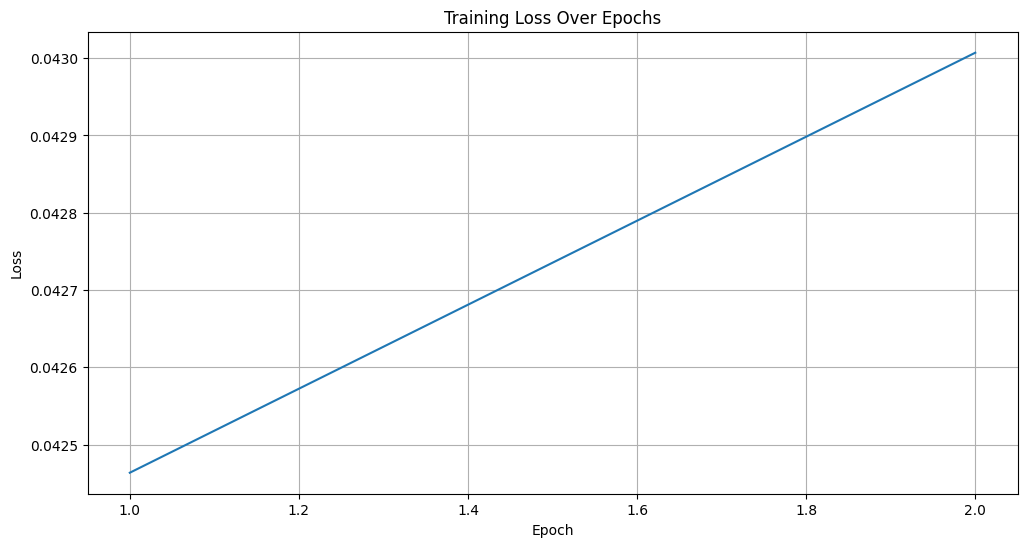

In [32]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=train_data, x="Epoch", y="Train Loss")
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

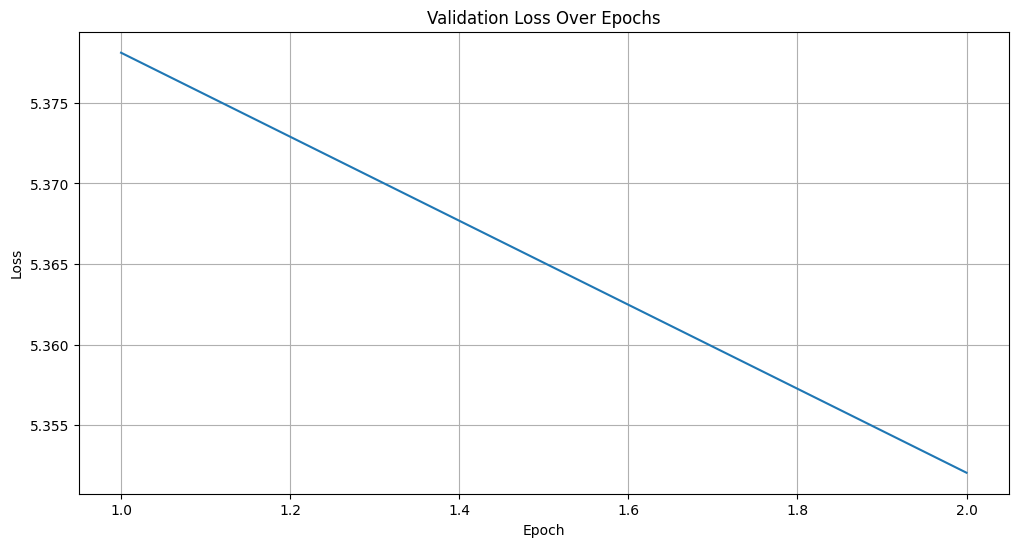

In [33]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=valid_data, x="Epoch", y="Validation Loss")
plt.title("Validation Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

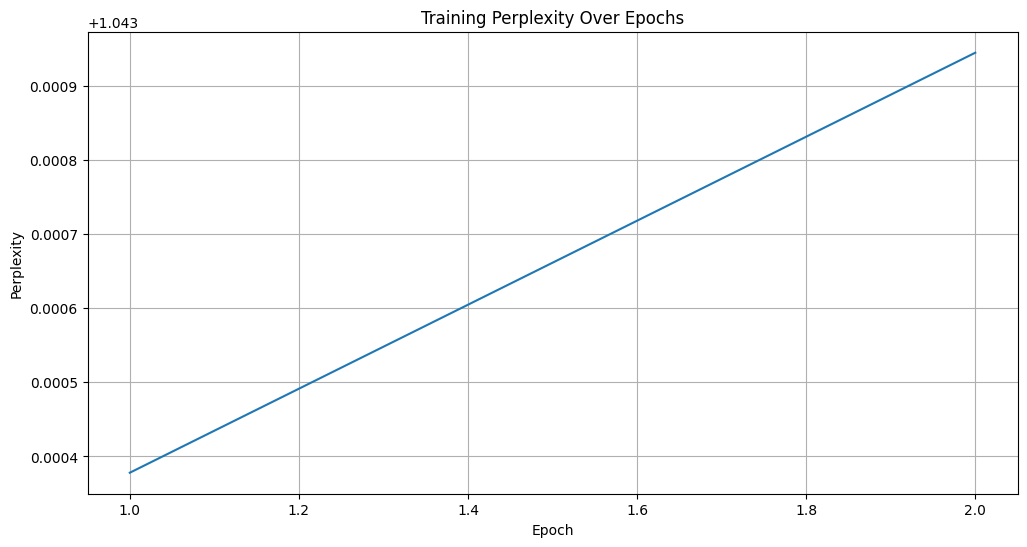

In [34]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=train_data, x="Epoch", y="Train Perplexity")
plt.title("Training Perplexity Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.grid(True)
plt.show()

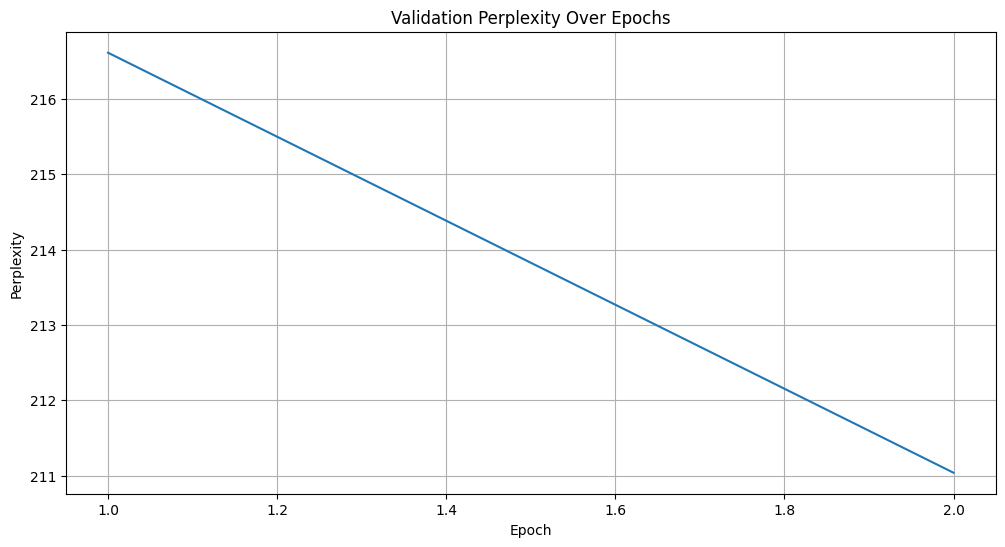

In [35]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=valid_data, x="Epoch", y="Validation Perplexity")
plt.title("Validation Perplexity Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.grid(True)
plt.show()